# architecture-17 ( Basic Classification ) 10 label strategy it is not usefully

## What's new:

1- Add


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


# Constants
SEQUENCE_LENGTH = 60
FORECAST_HORIZON = 10

2025-07-30 11:17:57.941740: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load dataset
df = pd.read_csv('datasets-17/XAGUSD-H1-rates.csv', sep='\t').dropna()

In [3]:
# Scaling Features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']])

In [4]:

# Label trend reversals (example: a simplistic method)
def label_trend_reversals(prices, window=5):
    labels = []
    for i in range(len(prices) - window):
        past = prices[i:i+window//2]
        future = prices[i+window//2:i+window]
        if np.mean(future) > np.mean(past):
            labels.append(1)  # potential buy
        elif np.mean(future) < np.mean(past):
            labels.append(2)  # potential sell
        else:
            labels.append(0)
    labels += [0] * window  # pad
    return labels

df['Label'] = label_trend_reversals(df['<CLOSE>'].values)


In [5]:
# Prepare Sequences
X, y = [], []
for i in range(SEQUENCE_LENGTH, len(scaled_data) - FORECAST_HORIZON):
    X.append(scaled_data[i-SEQUENCE_LENGTH:i])
    y.append(df['Label'].iloc[i:i+FORECAST_HORIZON].values)

X, y = np.array(X), np.array(y)
print(f"X shape: {X.shape}, y shape: {y.shape}")  # Debug info

X shape: (55013, 60, 5), y shape: (55013, 10)


In [10]:
# === Split dataset ===
X_train = X[:-1]
y_train = y[:-1]
X_test = X[-1:]
y_test = np.array([to_categorical(y[-1], num_classes=3)])  # One-hot encode test label

In [32]:
X_train.shape

(55012, 60, 5)

In [33]:
y_train.shape

(55012, 10)

In [34]:
X_test.shape

(1, 60, 5)

In [35]:
y_test.shape

(1, 10, 3)

In [12]:
# Last 60 candles for prediction
X_input = X[-1:]
y_true_future = y[-1]  # for evaluation if desired


In [13]:
X_input.shape

(1, 60, 5)

In [14]:
# One-hot encode each timestep's class (3 classes → depth = 3)
y_onehot = np.array([to_categorical(row, num_classes=3) for row in y_train])
# Now shape = (num_samples, 10, 3)


In [15]:
# Build LSTM Classification Model
model = Sequential([
    Input(shape=(SEQUENCE_LENGTH, X.shape[2])),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(FORECAST_HORIZON * 3, activation='softmax'),
    tf.keras.layers.Reshape((FORECAST_HORIZON, 3))
])


In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
# Fit model
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train,
    y_onehot,
    epochs=2,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/2


2025-07-30 11:22:36.626853: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 59412000 exceeds 10% of free system memory.


774/774 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.4981 - loss: 0.7651 - val_accuracy: 0.4988 - val_loss: 0.6960
Epoch 2/2
774/774 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.4992 - loss: 0.7016 - val_accuracy: 0.4957 - val_loss: 0.6969
Restoring model weights from the end of the best epoch: 1.


In [18]:
# === Load the last 60 candles from a CSV file ===
input_df = pd.read_csv(
    'datasets-17/new-data-for-test/rows-60-from-20240503/rows-60-from-20240503.csv',
    sep='\t'
).dropna()

# Combine <DATE> and <TIME> into a datetime column
input_df['DATETIME'] = pd.to_datetime(input_df['<DATE>'] + ' ' + input_df['<TIME>'])

# === Prepare features and scale ===
input_features = input_df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']]
input_scaled = scaler.transform(input_features)  # Use the same scaler from training

# Reshape for model: (1, 60, num_features)
input_sequence = np.expand_dims(input_scaled, axis=0)

# === Predict class probabilities ===
pred_probs = model.predict(input_sequence)  # e.g. shape: (1, 10 * 3)
forecast_horizon = 10
pred_classes = np.argmax(pred_probs.reshape(forecast_horizon, 3), axis=1)
print("Predicted Classes:", pred_classes)  # 0=no signal, 1=buy, 2=sell

# === Generate future timestamps ===
last_timestamp = input_df['DATETIME'].iloc[-1]
forecast_datetimes = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1),
                                   periods=forecast_horizon, freq='h')

# === Create predicted_df for plotting ===
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': pred_classes
})

# Convert class → label
def class_to_label(c):
    return 'buy' if c == 1 else 'sell' if c == 2 else None

predicted_df['label'] = predicted_df['forecast_class'].apply(class_to_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Predicted Classes: [2 2 1 1 1 2 2 2 2 2]


# plot section

In [19]:
import sys

sys.path.insert(1, '../utils')
import forex_plot_utils
import os

# PARAMETERS
csv1_path = 'datasets-17/new-data-for-test/rows-60-from-20240503/latest-4-for-history.csv'
csv3_path = 'datasets-17/new-data-for-test/rows-60-from-20240503/after.csv'
plot_title = 'Write a suitable title.'
output_plot_path = None  # e.g., 'output.png'

# LOAD DATA FROM CSVS
historical_df = forex_plot_utils.load_csv_with_datetime(csv1_path) if os.path.exists(csv1_path) else None
actual_future_df = forex_plot_utils.load_csv_with_datetime(csv3_path) if os.path.exists(csv3_path) else None


In [20]:

import pandas as pd

# === Generate forecast timestamps ===
# Start 1 hour after the last actual candle
last_timestamp = input_df['DATETIME'].iloc[-1]
forecast_datetimes = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=forecast_horizon, freq='h')

# === Create predicted_df with forecasted trend reversals ===
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': pred_classes
})

# Optional: Add labels for plotting
def class_to_label(c):
    if c == 1:
        return 'buy'
    elif c == 2:
        return 'sell'
    else:
        return None

predicted_df['label'] = predicted_df['forecast_class'].apply(class_to_label)


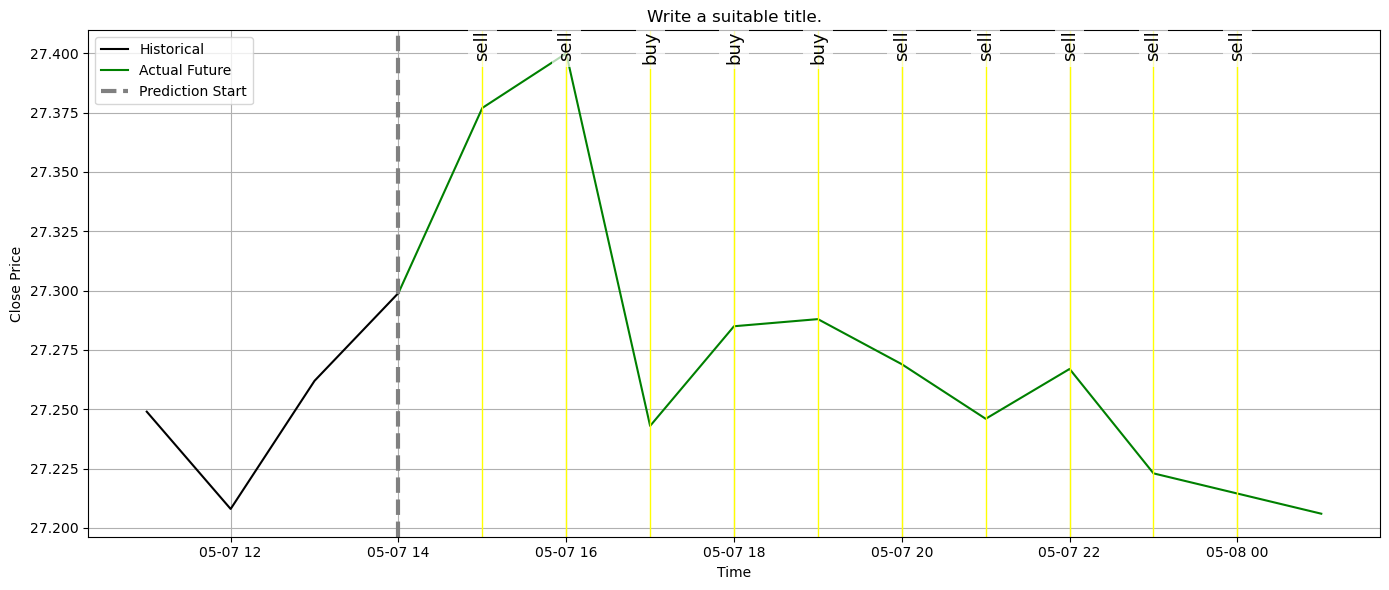

In [21]:
# PLOT
forex_plot_utils.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)

In [22]:
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Create timestamp and paths ===
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# === Save model ===
model.save(model_path)

# === Save training history ===
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# === Save training loss plot ===
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# === Save model summary and final performance ===
with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss, final_test_mae = model.evaluate(X_test, y_test, verbose=0)
    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss: {final_test_loss:.6f}\n')
    f.write(f'Final Test MAE : {final_test_mae:.6f}\n')
